In [1]:
# import required modules and classes
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_body, solar_system_ephemeris

from astropy.time import Time, TimeDelta, TimezoneInfo
import astropy.units as u

from astroplan import FixedTarget, Observer

from astroplan import (AltitudeConstraint, AirmassConstraint, 
                       AtNightConstraint, TimeConstraint, LocalTimeConstraint, time_grid_from_range, MissingConstraintWarning )
from astroplan import is_observable, is_always_observable, months_observable, observability_table

import datetime as dt
import pytz
import pendulum
import numpy as np

In [6]:
# define functions we need

from numpy import ndarray

def setup_onset_dark_times(start_date, observer:Observer, horizon) -> Time:
    # create an Astropy Time object covering a year's worth of observation samples
    # sample time is onset of darkness, defined as the time the sun sets below the horizon elevation
    # observer is the location of the observer
    # horizon: -6 = civil twilight, -12 = nautical, -18 = astronomical
    
    times = []
    start = pendulum.datetime(start_date.year, start_date.month, start_date.day, 0, 0,  0, tz='US/Central').in_tz('UTC')
    for i in range(0, 365):
        day = start.add(days=i) # adjust start date to the day we want
        sunset =observer.sun_set_time(Time(day), which='next', horizon=horizon*u.deg)
        times.append(sunset.iso)
    return Time(times)

def sample_planet_visibility(planet_name:str, sample_times:Time, observer:Observer):
    # get the planet's locations against the sample times
    sk =get_body(planet_name, sample_times, observer.location)
    # get altaz frames for times and location
    altaz_frames = AltAz(obstime=sample_times, location=observer.location)
    # transform the SKs to the altaz frames
    transformed = sk.transform_to(altaz_frames)
    return transformed

def sample_dso_visibility(dso_ft, sample_times:Time, observer:Observer) -> AltAz:
    # get the planet's locations against the sample times
    #sk =get_body(planet_name, sample_times, observer.location)
    sk = dso_ft.coord
    # get altaz frames for times and location
    altaz_frames = AltAz(obstime=sample_times, location=observer.location)
    # transform the SKs to the altaz frames
    transformed = sk.transform_to(altaz_frames)
    return transformed

# the db is a JSON file of objects I scraped from Stellarium
def load_dso_db(file_path) -> list[dict]:
    import json
    with open(file_path, 'r') as f:
        dso_db = json.load(f)
    return dso_db

# target cat numbers are the catalog numbers of the targets we want to observe
# dso field has a space like "M 45"
# Returns a list of FixedTarget objects, but we only need the .coord = SkyCoord attribute
def get_targets_from_db(dso_db:list[dict], target_cat_numbers: list[str]) -> list[FixedTarget]:
    targets = []
    for cat in target_cat_numbers:
        for dso in dso_db:
            if dso['catalog'].lower() == cat.lower():
                targets.append(FixedTarget(coord=SkyCoord(ra=dso['ra_dd']*u.deg, dec=dso['dec_dd']*u.deg), name=dso['name']))
    return targets

def calculate_altitudes_for_sample_times(dso_target_list:list[str], planet_list:list[str], 
                            times:Time, observer:Observer, ) -> tuple[ndarray, list[str]]:
    # build dsos and planets into target_day_altitude array
    # each row is a target (dso, then planets), each column is a day of the year (col 0 is Jan 1)
    # each cell has the altitude for that target on that day at the predetermined observation time
    # this will be used to determine which targets are visible on which days

    # load (or reload) the DSO database
    db_path = 'sky_database.json'
    dso_db = load_dso_db(db_path)

    # get the dso target RA/Dec from the db
    dso_targets = get_targets_from_db(dso_db, dso_target_list)
    
    # sort DSO targets in ra order
    dso_targets.sort(key=lambda x: x.ra.hour)

    # extract names in same order as the targets
    assert len(dso_targets) > 0, "No DSO targets found in the database"
    target_names:list[str] | list = [t.name for t in dso_targets]
    assert len(target_names) > 0, "DSO targetes did not have names in the database"

    # if any planets are listed, add in planet names to the end
    if len(planet_list) > 0:
        target_names.extend(planet_list)

    # allocate the np array
    target_count = len(dso_targets) + len(planet_list)
    time_count = len(times)
    target_day_altitude = np.zeros((target_count, time_count), dtype=float)

    # populate the tda array first with dso targets, then with planets
    for i in range(len(dso_targets)):
        tr_altaz = sample_dso_visibility(dso_targets[i], times, observer)
        for j in range(len(tr_altaz)):
            target_day_altitude[i][j] = tr_altaz[j].alt.degree
    
    if len(planet_list) > 0:
        for i in range(len(planet_list)):
            tr_altaz = sample_planet_visibility(planet_list[i], times, observer)
            for j in range(len(tr_altaz)):
                target_day_altitude[i + len(dso_targets)][j] = tr_altaz[j].alt.degree

    return target_day_altitude, target_names

In [7]:
# matplotlib is used to plot the visibility of the targets
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox

def plot_sky_chart(observer, target_names, tg_day_alt, hours, min_ele, 
                target_class, public_nights, print_file_path=None):
    
    num_dso = len(target_names)
    num_days = 365

    assert tg_day_alt.shape[0] == num_dso, "Number of targets and number of intervals do not match"
    assert tg_day_alt.shape[1] == num_days, "Number of targets and number of intervals do not match"

    data = np.zeros((num_dso, num_days), dtype=int)

    # convert altitudes to 1 or 0 based on min-elevation
    # for each target
    for tg in range(tg_day_alt.shape[0]):
        # for each day (0 = Jan 1, 364 = Dec 31)
        for day in range(tg_day_alt.shape[1]):
            data[tg, day] = 1 if tg_day_alt[tg][day] >= min_ele else 0  

    fig, ax = plt.subplots(figsize=(8.5,11))  # Landscape orientation
    # fig_off, ax_off = plt.subplots(figsize=(11, 8.5))  # Landscape orientation

    y_lim = num_dso
    
    ax.invert_yaxis() # put y = 0 at top
    ax.set_xlim(0, 364)
    ax.set_ylim(-1, y_lim)

    row_counter = 0
    for row in data:
        # skip objects not visible at all
        if not row.any() :
            continue
        for j, visible in enumerate(row): # across the days in this row (this dso)
            if visible:
                if j == 0 or not row[j-1]:
                    start = j
                if j == len(row)-1 or not row[j+1]:
                    end = j
                    ax.plot([start, end], [row_counter, row_counter], 'b', lw=2)
                    if end - start > 10:
                        # print(f"{targets[i].name} = {get_text_width(fig,ax,{targets[i].name}, 9)}")
                        if start <= 1:
                            start = 2
                            ax.text(start, row_counter, 
                                target_names[row_counter], color='black', fontsize=9, ha='left', va='bottom')
                        elif end >= 362:
                            end = 362
                            ax.text(end, row_counter, 
                                target_names[row_counter], color='black', fontsize=9, ha='right', va='bottom')
                        else:
                            ax.text(start + (end - start)/2, row_counter, 
                                target_names[row_counter], color='black', fontsize=9, ha='center', va='bottom')
        row_counter += 1

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    # month_weeks = np.arange(0, 51, 4.33)
    month_days = [dt.datetime(2024,m,1).timetuple().tm_yday for m in range(1,13)]

    ax.set_yticks([])
    # ax.set_yticklabels([f'{targets[i].name}' for i in range(num_dso)])
    ax.set_xticks(month_days)
    ax.set_xticklabels(months)
    ax.set_xlabel('Date')
    # ax.set_ylabel('Targets for Ruisinger Imaging')
    ax.set_title(
        f"""Visibility of {target_class} at {observer.name}
        Obs. Hours: {hours}  Min Elevation: {min_ele} degrees
        """)
                
    for pn in public_nights:
        # plt.axvline(x=special_mark, y=1, color='red', linewidth=0.5)
        x_val = pn.timetuple().tm_yday
        plt.plot([x_val, x_val], [y_lim-.4, y_lim], color='blue', linewidth=0.5)

    # Adding minor ticks for weeks
    # ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True, which='major', axis='x', linestyle=':', linewidth=0.8)
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()
    if print_file_path:
        fig.savefig(print_file_path, format='jpg', dpi=300)

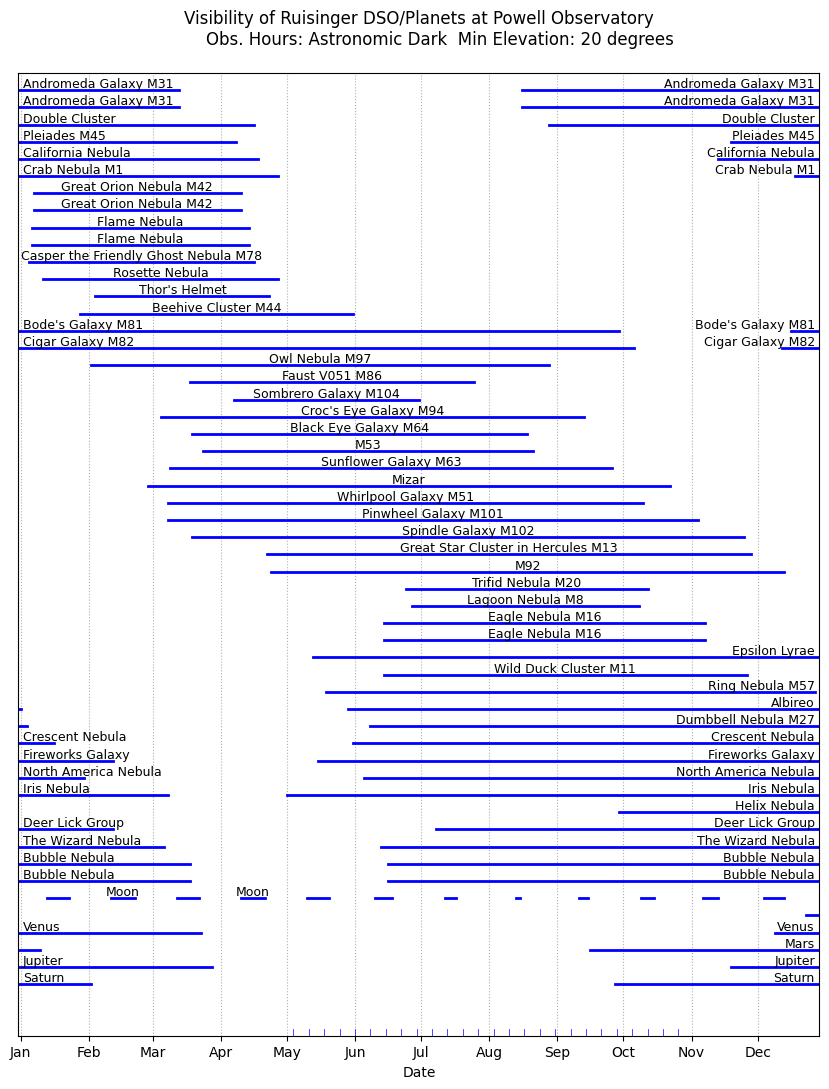

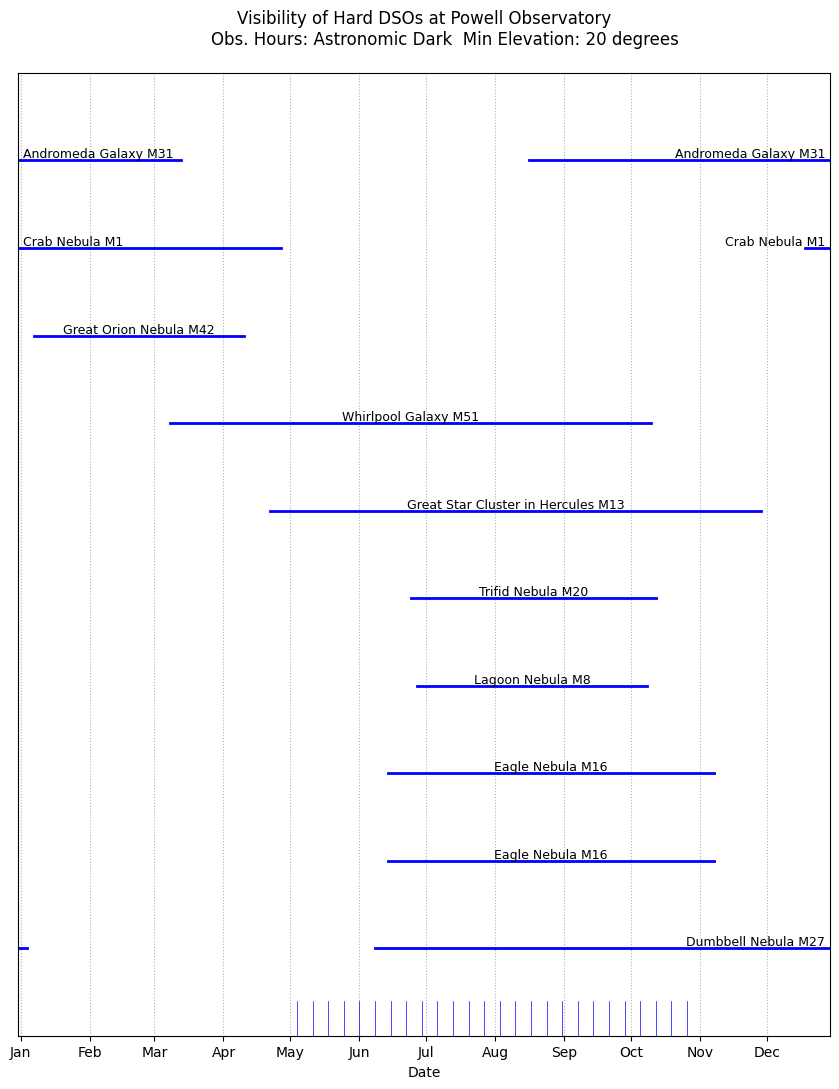

In [9]:
# define stuff about the observer, the targets, etc
# define our observatory (Powell Observatory)

powell = Observer(latitude=38.64633*u.deg, longitude=-94.699973*u.deg,
                   elevation=300*u.m, name="Powell Observatory", timezone="US/Central")

local_tzone = pytz.timezone("US/Central")
utc_tzone = pytz.timezone("UTC")

sample_year = 2024

public_nights = [dt.datetime(2024,5,4), dt.datetime(2024, 5,11), dt.datetime(2024, 5,18),
                    dt.datetime(2024, 5,25), dt.datetime(2024, 6,1), dt.datetime(2024, 6,8),
                    dt.datetime(2024, 6,15), dt.datetime(2024, 6,22), dt.datetime(2024, 6,29),
                    dt.datetime(2024, 7,6), dt.datetime(2024, 7,13), dt.datetime(2024, 7,20),
                    dt.datetime(2024, 7,27), dt.datetime(2024, 8,3), dt.datetime(2024, 8,10),
                    dt.datetime(2024, 8,17), dt.datetime(2024, 8,24), dt.datetime(2024, 8,31),
                    dt.datetime(2024, 9,7), dt.datetime(2024, 9,14), dt.datetime(2024, 9,21),
                    dt.datetime(2024, 9,28), dt.datetime(2024, 10,5), dt.datetime(2024, 10,12),
                    dt.datetime(2024, 10,19), dt.datetime(2024, 10,26)]

# generate the sampling times (Astropy Time objects) 
# one sample per day of year, taken after sundown (see horizon note)
# -18 gives astronomical dark
# this is actually pretty slow ~ 8 seconds for 365 days

times = setup_onset_dark_times(dt.datetime(sample_year, 1, 1), powell, -18)

# define some targets
ruisinger_dsos = ['M 1', 'M 8', 'M 16',  'M 13', 'M 16', 'M 20', 'M 27', 'M 31', 'M 42', 'M 51', 
                    'M 53', 'M 57', 'M 63', 'M 64', 'M 78', 'M 81', 'M 82', 'M 86', 'M 92', 'M 94', 'M 101', 'M 102', 'M 104', 
                    'NGC 7293', 'NGC 7320', 'NGC 7635', 'NGC 6888', 'NGC 6946', 'NGC 7331', 
                    'NGC 2359', 'NGC 2023', 'NGC 2024', 'NGC 7380', 'NGC 7635', 'NGC 7023', 'NGC 4565',
                    'SH2 279', 'Albireo', 'Mizar', 'Epsilon Lyrae'  ]

widefield_dsos = ['M 11', 'M 31', 'M 45', 'M 42', 'NGC 2238', 'NGC 1499', 'IC 1805', 'IC 1396', 'IC 1848', 'M 44', 'M 97', 
                  'NGC 884', 'NGC 6995', 'NGC 2024', 'NGC 7000']

ruisinger_dsos += widefield_dsos

planets = ['Moon', 'Mercury', 'Venus', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune' ]

# calculate the altitudes for the targets at the sample times
target_day_altitude, target_names = calculate_altitudes_for_sample_times(ruisinger_dsos, planets, times, powell, )

min_ele = 20
plot_sky_chart(powell, target_names, target_day_altitude, "Astronomic Dark", min_ele, 
                "Ruisinger DSO/Planets", public_nights, print_file_path=None)

# second chart
hard_dsos = ['M 1', 'M 8', 'M 16',  'M 13', 'M 16', 'M 20', 'M 27', 'M 31', 'M 42', 'M 51']
planets = []

target_day_altitude, target_names = calculate_altitudes_for_sample_times(hard_dsos, planets, times, powell, )

min_ele = 20
plot_sky_chart(powell, target_names, target_day_altitude, "Astronomic Dark", min_ele, 
                "Hard DSOs", public_nights, print_file_path=None)
